In [32]:
import pandas as pd

In [ ]:
pixels = pd.read_csv("flattened_images.csv")
train_metadata = pd.read_csv("../train/train_metadata.csv")


In [34]:
merged_df = pixels.merge(train_metadata, on='image_path')
X = merged_df[[f'pixel_{i}' for i in range(1024)]].values
y = merged_df['ClassId'].values

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
clf = MLPClassifier(hidden_layer_sizes=(500,), max_iter=300, random_state=42)

# Train
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6129


In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Assuming y and y_pred are already defined as in your code

# 1. Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Print classification report (precision, recall, f1-score per class)
#print(classification_report(y_test, y_pred))

# 3. Identify most misclassified classes

# Number of classes
num_classes = cm.shape[0]

# For each class, calculate how many samples were misclassified (i.e., total samples - correctly predicted)
misclassified_counts = cm.sum(axis=1) - np.diag(cm)

# Put results in a DataFrame for easier viewing
df_misclass = pd.DataFrame({
    'Class': range(num_classes),  # or use your actual class labels if you have a mapping
    'Misclassified Count': misclassified_counts,
    'Total Samples': cm.sum(axis=1),
    'Misclassification Rate': misclassified_counts / cm.sum(axis=1)
})

# Sort by highest misclassification rate or count
df_misclass_sorted = df_misclass.sort_values(by='Misclassification Rate', ascending=False)
display(df_misclass_sorted.head(40))  # top 10 worst classes

,Class,Misclassified Count,Total Samples,Misclassification Rate
0,0,9,9,1.000000
19,19,7,7,1.000000
37,37,4,5,0.800000
40,40,7,9,0.777778
24,24,5,7,0.714286
27,27,4,6,0.666667
28,28,10,15,0.666667
21,21,6,9,0.666667
3,3,24,37,0.648649
30,30,9,14,0.642857


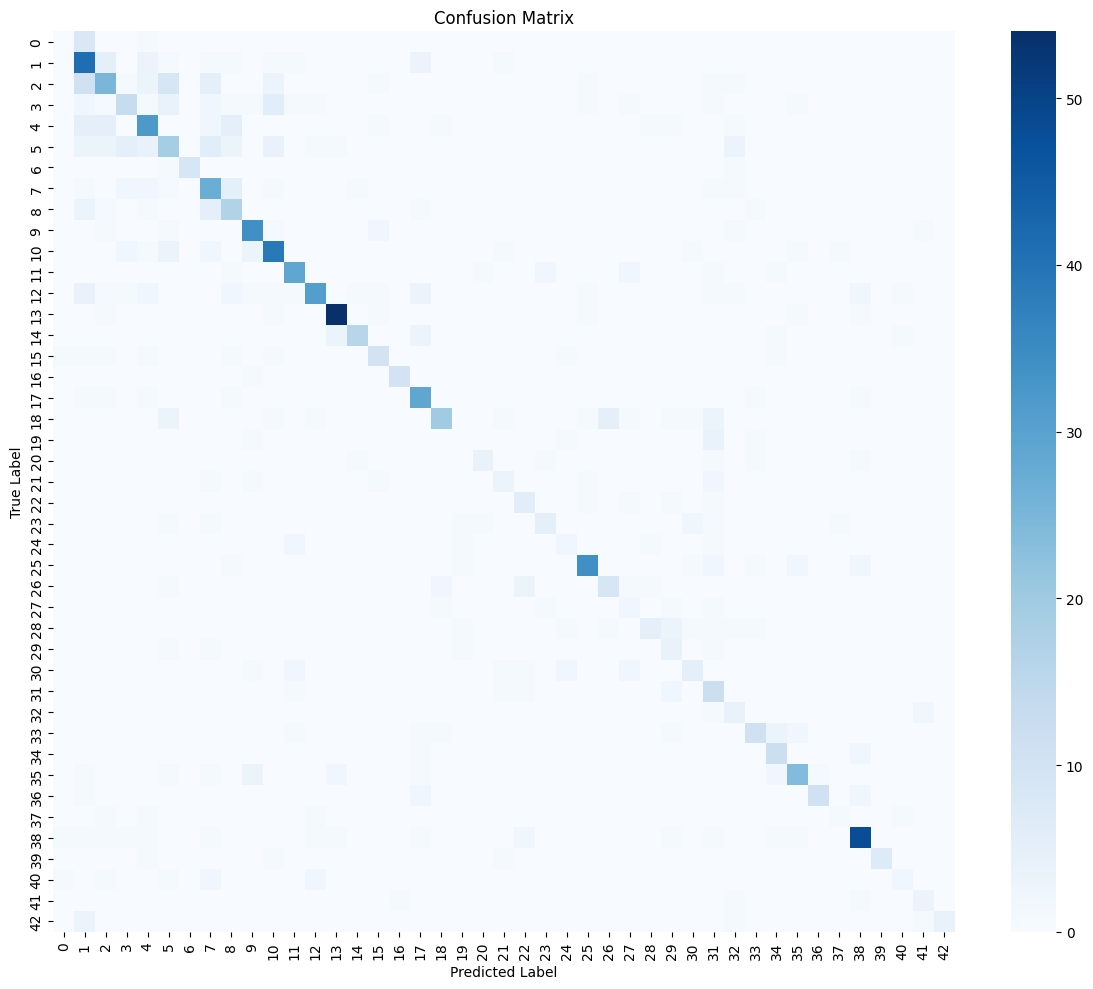

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix (you already have this)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')  # annot=True if you want numbers in cells

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Trying with derived features

In [15]:
hog_pca = pd.read_csv("train/Features/hog_pca.csv")
color_hist = pd.read_csv("train/Features/color_histogram.csv")
additional_features = pd.read_csv("train/Features/additional_features.csv")

In [16]:
hog_pca = hog_pca.merge(color_hist, on='image_path')

# Merge additional_features into the result
hog_pca = hog_pca.merge(additional_features, on='image_path')
pixels = hog_pca

In [20]:
merged_df = pixels.merge(train_metadata, on='image_path')
X = merged_df.drop(['image_path', 'ClassId'], axis = 1).values
y = merged_df['ClassId'].values

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
clf = MLPClassifier(hidden_layer_sizes=(20,20), max_iter=300, random_state=42)

# Train
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6284


# Bootstrapping

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
import numpy as np

# Merge image vectors with metadata
merged_df = pixels.merge(train_metadata, on='image_path')

# Split into train/test BEFORE resampling
train_df, test_df = train_test_split(
    merged_df,
    test_size=0.2,
    stratify=merged_df['ClassId'],
    random_state=42
)

# Group training set by class
grouped = train_df.groupby('ClassId')

# Target: match the largest class size
target_count = grouped.size().max()

# Resample each class in the training set
train_balanced_df = pd.concat([
    resample(group, replace=True, n_samples=target_count, random_state=42)
    for _, group in grouped
])

# Shuffle the training set
train_balanced_df = train_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X_train = train_balanced_df[[f'pixel_{i}' for i in range(1024)]].values
y_train = train_balanced_df['ClassId'].values

X_test = test_df[[f'pixel_{i}' for i in range(1024)]].values
y_test = test_df['ClassId'].values

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into train/test sets
#X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Define the model
clf = MLPClassifier(hidden_layer_sizes=(500,), max_iter=300, random_state=42)
# clf = MLPClassifier(max_iter=2000)

# Train
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.3005


In [55]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Assuming y and y_pred are already defined as in your code

# 1. Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Print classification report (precision, recall, f1-score per class)
#print(classification_report(y_test, y_pred))

# 3. Identify most misclassified classes

# Number of classes
num_classes = cm.shape[0]

# For each class, calculate how many samples were misclassified (i.e., total samples - correctly predicted)
misclassified_counts = cm.sum(axis=1) - np.diag(cm)

# Put results in a DataFrame for easier viewing
df_misclass = pd.DataFrame({
    'Class': range(num_classes),  # or use your actual class labels if you have a mapping
    'Misclassified Count': misclassified_counts,
    'Total Samples': cm.sum(axis=1),
    'Misclassification Rate': misclassified_counts / cm.sum(axis=1)
})

# Sort by highest misclassification rate or count
df_misclass_sorted = df_misclass.sort_values(by='Misclassification Rate', ascending=False)
display(df_misclass_sorted.head(40))  # top 10 worst classes

,Class,Misclassified Count,Total Samples,Misclassification Rate
9,9,41,41,1.000000
39,39,8,8,1.000000
24,24,8,8,1.000000
10,10,54,56,0.964286
35,35,32,34,0.941176
1,1,58,62,0.935484
30,30,12,13,0.923077
40,40,9,10,0.900000
2,2,56,63,0.888889
15,15,16,18,0.888889


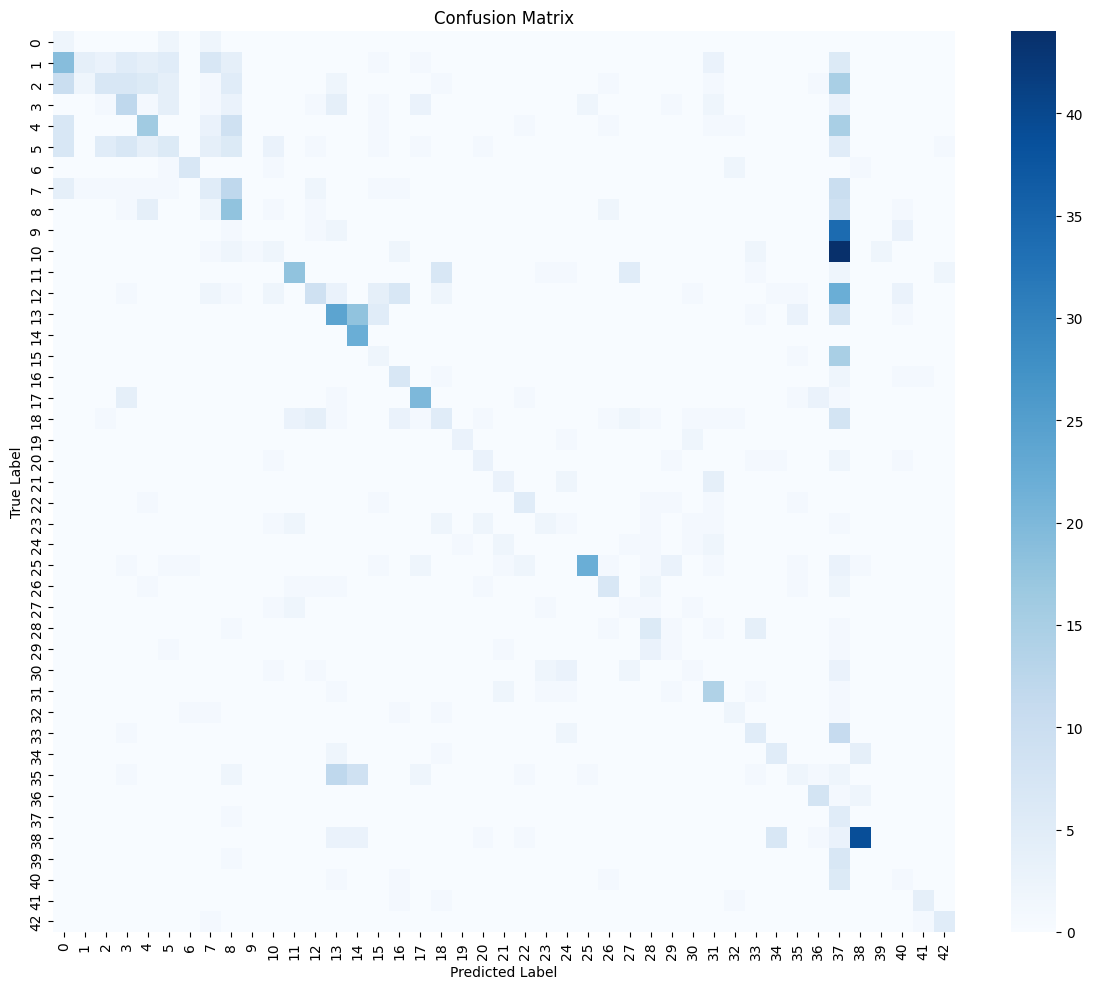

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix (you already have this)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')  # annot=True if you want numbers in cells

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()